# Domain Generalization (IRM) on PACS

In [1]:
import os
import random
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset, Subset, random_split
from torchvision import transforms, datasets

from irm import IRMTrainer, RemapLabels  # assume RemapLabels from your local code

# ----- Config -----
DATA_ROOT = Path(r"C:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\Datasets\pacs_data\pacs_data")
SOURCE_DOMAINS = ["art_painting", "cartoon", "photo"]
TARGET_DOMAIN = "sketch"

IMAGE_SIZE = 224
PER_DOMAIN_BATCH = 64                # DomainBed convention: batch size per domain
NUM_EPOCHS = 50
STEPS_PER_VAL = 75                     # evaluate every 75 steps (you previously used 75)
BASE_LR = 1e-4
WEIGHT_DECAY = 0.0
IRM_LAMBDA = 1e3
PENALTY_ANNEAL_ITERS = 500
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(SEED)
torch.manual_seed(SEED)

c:\Users\Fatim_Sproj\anaconda3\envs\bacp\lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

def load_imagefolder(domain_name, transform):
    p = DATA_ROOT / domain_name
    if not p.exists():
        raise FileNotFoundError(f"Domain path not found: {p.resolve()}")
    return datasets.ImageFolder(str(p), transform=transform)

# ----- Raw datasets per domain (before remap & split) -----
raw_sources = {d: load_imagefolder(d, train_transform) for d in SOURCE_DOMAINS}
raw_target = load_imagefolder(TARGET_DOMAIN, val_transform)

canonical_map = raw_sources[SOURCE_DOMAINS[0]].class_to_idx
NUM_CLASSES = len(canonical_map)

# Remap labels and split each source domain into train/val (DomainBed: use within-source val)
source_train_loaders = {}
source_val_loaders = {}
for d, raw_ds in raw_sources.items():
    remapped = RemapLabels(raw_ds, canonical_map)
    n = len(remapped)
    # DomainBed tends to use an 80/20 train/val split per domain (consistent with DomainBed practice)
    val_size = int(0.2 * n)
    train_size = n - val_size
    train_ds, val_ds = random_split(remapped, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
    source_train_loaders[d] = DataLoader(train_ds, batch_size=PER_DOMAIN_BATCH, shuffle=True, num_workers=0, pin_memory=True)
    source_val_loaders[d] = DataLoader(val_ds, batch_size=PER_DOMAIN_BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Target loader (test only)
target_dataset = RemapLabels(raw_target, canonical_map)
target_loader = DataLoader(target_dataset, batch_size=PER_DOMAIN_BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Print sizes
total_train_examples = sum(len(loader.dataset) for loader in source_train_loaders.values())
total_val_examples = sum(len(loader.dataset) for loader in source_val_loaders.values())
print(f"Total train examples (all domains): {total_train_examples}, total per-domain val examples: {total_val_examples//len(source_val_loaders)}")
print(f"Num classes: {NUM_CLASSES}")

Total train examples (all domains): 4843, total per-domain val examples: 403
Num classes: 7


In [3]:
import torchvision

class DomainBedModel(nn.Module):
    def __init__(self, featurizer, classifier, dropout_rate=0.0):
        super().__init__()
        self.featurizer = featurizer
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = classifier

    def forward(self, x):
        features = self.featurizer(x)
        features_dropped_out = self.dropout(features)
        return self.fc(features_dropped_out)

resnet_dropout = 0.0
freeze_bn_flag = True

base_model = torchvision.models.resnet18(pretrained=True)
n_outputs = base_model.fc.in_features
base_model.fc = nn.Identity()
featurizer = base_model

if freeze_bn_flag:
    for module in featurizer.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.eval()

classifier = nn.Linear(n_outputs, NUM_CLASSES)

model = DomainBedModel(featurizer, classifier, dropout_rate=resnet_dropout).to(DEVICE)

c:\Users\Fatim_Sproj\anaconda3\envs\bacp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Fatim_Sproj\anaconda3\envs\bacp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# ----- IRMTrainer setup -----
hparams = {
    'lr': BASE_LR,
    'weight_decay': WEIGHT_DECAY,
    'irm_lambda': IRM_LAMBDA,
    'penalty_anneal_iters': PENALTY_ANNEAL_ITERS
}

irm_algo = IRMTrainer(
    model=model,
    optimizer=None,
    irm_lambda=hparams["irm_lambda"],
    penalty_anneal_iters=hparams["penalty_anneal_iters"],
    device=DEVICE
)

optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'], weight_decay=hparams['weight_decay'])
irm_algo.optimizer = optimizer

@torch.no_grad()
def evaluate_on_loader(model, loader, device):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)
    return total_loss / total, 100.0 * correct / total

def evaluate_on_source_val(model, source_val_loaders, device):
    losses, accs, ns = [], [], []
    for d, loader in source_val_loaders.items():
        loss, acc = evaluate_on_loader(model, loader, device)
        losses.append(loss * len(loader.dataset))
        accs.append(acc * len(loader.dataset) / 100.0)
        ns.append(len(loader.dataset))
    total_n = sum(ns)
    avg_loss = sum(losses) / total_n
    avg_acc = 100.0 * (sum(accs) / total_n)
    return avg_loss, avg_acc

Training for 1050 total steps (synchronized across domains)


IRM Train (steps):   7%|▋         | 75/1050 [00:31<36:19,  2.24s/it, loss=0.383, nll=0.351, pen=0.032] 


Step 75/1050 | Target loss: 1.2139, target acc: 62.20%
Saved best model (Target acc: 62.20%)


IRM Train (steps):  14%|█▍        | 150/1050 [01:15<1:18:31,  5.23s/it, loss=0.2, nll=0.183, pen=0.0172]


Step 150/1050 | Target loss: 1.3149, target acc: 60.35%


IRM Train (steps):  21%|██▏       | 225/1050 [02:11<1:04:41,  4.70s/it, loss=0.135, nll=0.123, pen=0.0117]


Step 225/1050 | Target loss: 1.4460, target acc: 60.45%


IRM Train (steps):  29%|██▊       | 300/1050 [02:47<37:07,  2.97s/it, loss=0.102, nll=0.0928, pen=0.0088] 


Step 300/1050 | Target loss: 1.5210, target acc: 60.35%


IRM Train (steps):  36%|███▌      | 375/1050 [03:40<28:09,  2.50s/it, loss=0.0817, nll=0.0746, pen=0.00707]


Step 375/1050 | Target loss: 1.4495, target acc: 62.03%


IRM Train (steps):  43%|████▎     | 450/1050 [04:14<23:16,  2.33s/it, loss=0.0683, nll=0.0624, pen=0.00591]


Step 450/1050 | Target loss: 1.6604, target acc: 58.16%


IRM Train (steps):  50%|█████     | 525/1050 [04:48<20:27,  2.34s/it, loss=0.0588, nll=0.0539, pen=0.00508]


Step 525/1050 | Target loss: 1.6936, target acc: 57.72%


IRM Train (steps):  57%|█████▋    | 600/1050 [05:38<29:09,  3.89s/it, loss=0.0518, nll=0.0516, pen=0.00476]


Step 600/1050 | Target loss: 1.9452, target acc: 49.05%


IRM Train (steps):  64%|██████▍   | 675/1050 [06:33<24:40,  3.95s/it, loss=0.0467, nll=0.0586, pen=0.00492]


Step 675/1050 | Target loss: 1.0291, target acc: 64.19%
Saved best model (Target acc: 64.19%)


IRM Train (steps):  71%|███████▏  | 750/1050 [07:30<20:31,  4.11s/it, loss=0.0425, nll=0.0603, pen=0.00481]


Step 750/1050 | Target loss: 0.9240, target acc: 64.93%
Saved best model (Target acc: 64.93%)


IRM Train (steps):  79%|███████▊  | 825/1050 [08:27<15:12,  4.06s/it, loss=0.0387, nll=0.0589, pen=0.0045] 


Step 825/1050 | Target loss: 1.0113, target acc: 64.65%


IRM Train (steps):  86%|████████▌ | 900/1050 [09:10<05:36,  2.24s/it, loss=0.0356, nll=0.0564, pen=0.0042] 


Step 900/1050 | Target loss: 0.8794, target acc: 68.19%
Saved best model (Target acc: 68.19%)


IRM Train (steps):  93%|█████████▎| 975/1050 [09:48<05:24,  4.33s/it, loss=0.0329, nll=0.0534, pen=0.00392]


Step 975/1050 | Target loss: 0.9450, target acc: 67.78%


IRM Train (steps): 100%|██████████| 1050/1050 [10:52<00:00,  1.61it/s, loss=0.0306, nll=0.0502, pen=0.00366]


Step 1050/1050 | Target loss: 1.0187, target acc: 66.17%

Best target-domain accuracy (IRM): 68.19%


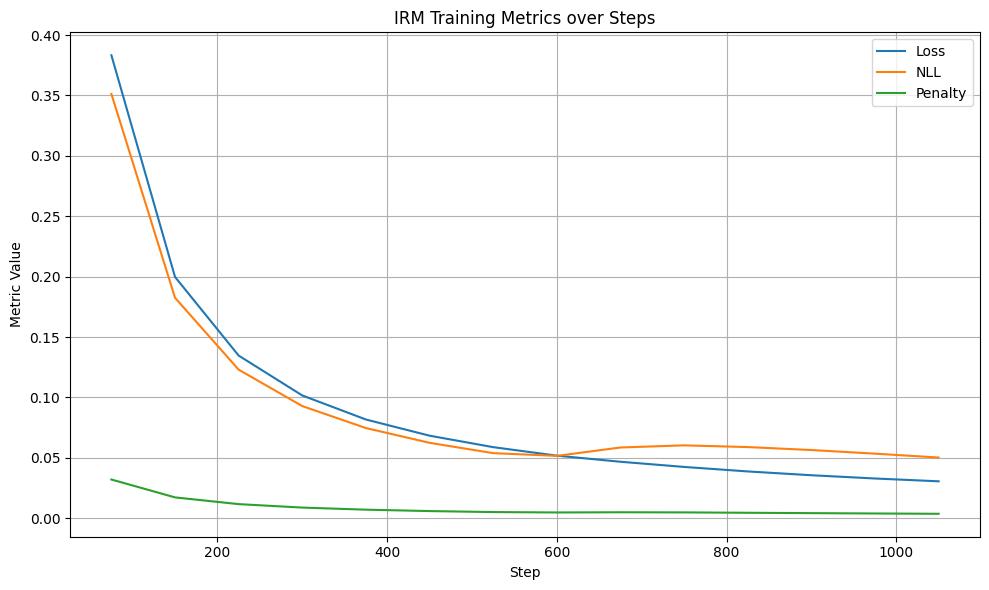

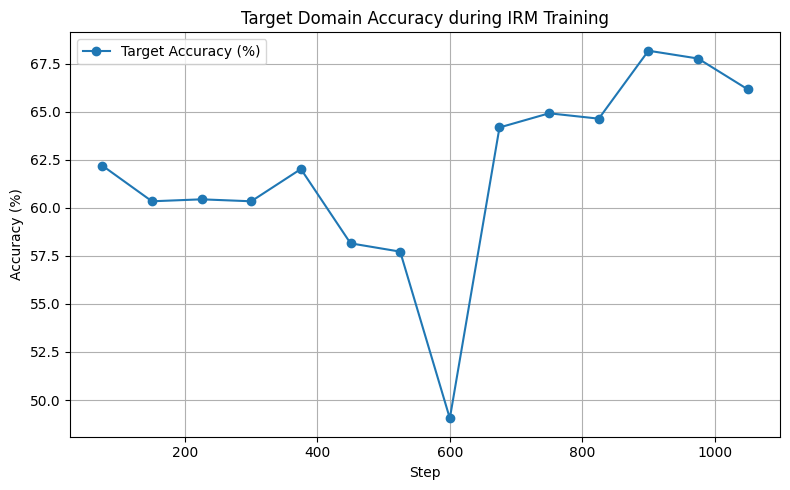

In [5]:
import matplotlib.pyplot as plt
import json
from pathlib import Path
from tqdm import tqdm
import torch

# ---------- IRM TRAINING WITH LOGGING ----------
best_target_acc = 0.0
OUTPUT_DIR = Path('./irm_outputs_domainbed_style')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# metric storage
logs = {"step": [], "loss": [], "nll": [], "penalty": [], "target_acc": []}

source_train_loader_list = [source_train_loaders[d] for d in SOURCE_DOMAINS]
min_steps_per_domain = min(len(dl) for dl in source_train_loader_list)
total_steps = NUM_EPOCHS * min_steps_per_domain
print(f"Training for {total_steps} total steps (synchronized across domains)")

iters = [iter(dl) for dl in source_train_loader_list]
optimizer_was_reset = False
step_metrics = {"loss": 0.0, "nll": 0.0, "penalty": 0.0}

pbar = tqdm(range(total_steps), desc="IRM Train (steps)", leave=True)

for step in pbar:
    # reset optimizer after anneal point
    if irm_algo.iteration >= hparams['penalty_anneal_iters'] and not optimizer_was_reset:
        optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'], weight_decay=hparams['weight_decay'])
        irm_algo.optimizer = optimizer
        optimizer_was_reset = True

    # construct minibatches across source domains
    minibatches = []
    for i, it in enumerate(iters):
        try:
            x, y = next(it)
        except StopIteration:
            iters[i] = iter(source_train_loader_list[i])
            x, y = next(iters[i])
        minibatches.append((x.to(DEVICE), y.to(DEVICE)))

    # IRM update
    metrics = irm_algo.step(minibatches)
    for k in ("loss", "nll", "penalty"):
        step_metrics[k] += metrics.get(k, 0.0)

    avg_metrics = {k: step_metrics[k] / (step + 1) for k in step_metrics}
    pbar.set_postfix({
        "loss": avg_metrics["loss"],
        "nll": avg_metrics["nll"],
        "pen": avg_metrics["penalty"]
    })

    # periodic evaluation
    if (step + 1) % STEPS_PER_VAL == 0 or step == total_steps - 1:
        target_loss, target_acc = evaluate_on_loader(model, target_loader, DEVICE)

        print(f"\nStep {step+1}/{total_steps} | Target loss: {target_loss:.4f}, target acc: {target_acc:.2f}%")

        # log step metrics
        logs["step"].append(step + 1)
        logs["loss"].append(avg_metrics["loss"])
        logs["nll"].append(avg_metrics["nll"])
        logs["penalty"].append(avg_metrics["penalty"])
        logs["target_acc"].append(target_acc)

        # checkpoint best model
        if target_acc > best_target_acc:
            best_target_acc = target_acc
            torch.save(model.state_dict(), OUTPUT_DIR / 'best_model_irm_domainbed.pth')
            print(f"Saved best model (Target acc: {target_acc:.2f}%)")

print(f"\nBest target-domain accuracy (IRM): {best_target_acc:.2f}%")

# save logs to json
with open(OUTPUT_DIR / "irm_training_log.json", "w") as f:
    json.dump(logs, f)

# ---------- Plot curves ----------
plt.figure(figsize=(10,6))
plt.plot(logs["step"], logs["loss"], label="Loss")
plt.plot(logs["step"], logs["nll"], label="NLL")
plt.plot(logs["step"], logs["penalty"], label="Penalty")
plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.title("IRM Training Metrics over Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "irm_training_curves.png", dpi=200)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(logs["step"], logs["target_acc"], marker='o', label="Target Accuracy (%)")
plt.xlabel("Step")
plt.ylabel("Accuracy (%)")
plt.title("Target Domain Accuracy during IRM Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "irm_target_accuracy_curve.png", dpi=200)
plt.show()


In [6]:
import torch
import matplotlib.pyplot as plt

# ---------- Load best saved model ----------
best_model_path = OUTPUT_DIR / 'best_model_irm_domainbed.pth'

model = DomainBedModel(
    featurizer,
    classifier,
    dropout_rate=resnet_dropout
).to(DEVICE)

assert best_model_path.exists(), "No best model found!"
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model.eval()

domain_names = SOURCE_DOMAINS + [TARGET_DOMAIN]
domain_loaders = [source_val_loaders[d] for d in SOURCE_DOMAINS] + [target_loader]
domain_accuracies = []

for name, loader in zip(domain_names, domain_loaders):
    loss, acc = evaluate_on_loader(model, loader, DEVICE)
    domain_accuracies.append(acc)
    print(f"{name:<15} | Loss: {loss:.4f} | Acc: {acc:.2f}%")

# ---------- Bar plot ----------
plt.figure(figsize=(8, 5))
bars = plt.bar(domain_names, domain_accuracies, color='skyblue', edgecolor='black', linewidth=1.2)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Per-Domain Accuracy (ERM Final Model)", fontsize=13, pad=10)

plt.xticks(range(len(domain_names)), domain_accuracies, rotation=0, ha='center', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "domain_accuracy_bar.png", dpi=300, bbox_inches='tight')
plt.close()


C:\Users\Fatim_Sproj\AppData\Local\Temp\ipykernel_30964\3631006738.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map

art_painting    | Loss: 0.3686 | Acc: 88.70%
cartoon         | Loss: 0.4313 | Acc: 86.75%
photo           | Loss: 0.0708 | Acc: 97.90%
sketch          | Loss: 0.8794 | Acc: 68.19%
